# COGS 108 - Final Project 

# Overview

*In this project, I intend to identify a relationship between the frequency of crime near a park and whether or not they have a Rec Center. I use datasets particular to San Diego parks to predict the Yelp rating a park gets in San Diego. From this analysis, I found *

# Name & GitHub

- Name: Adrian Mendoza
- GitHub Username: AdrianMendozaCodes

# Research Question

*Can factors such as a Park having a Rec Center and the number of crimes near the park predict the rating a park will get on a Yelp Review. For this study I will only focus on parks in San Diego.*

## Background and Prior Work

View the rating of parks in San Diego there seems to be more positive comments and thus postive reviews for higher rated parks. Therefore, the more postive reviews may be correlated to a park having a Rec Center and having low number of crimes occur near the park. One speculation that comes to mind is that poorer areas will not have a Rec Center and will have gangs which will mean high crime rates near the park. Growing up in a poor area in LA and having a Rec Center in the park nearest me only made the park safe during the day, but once evening/night time came the gangs would take over the park thus make over the park not a good park. Out of a rating of 5 I would give it a 3 at most. It will be interseting to see how parks with high crimes near them rate with and without a Rec Center.

I could not find any research done on how crime rates near a park in San Diego affect its yelp rating, but I did find that San Diego restaurants make a lot of money off of tourist dollars and if they have a negative Yelp reviews it could cause the business a lot of money.(1) In the same way if parks are getting bad reviews what's to stop the County officals from lowering the funding of the park in following years, potentially causing the park to shut down.

In another article the 2020 COVID-19 virus has caused an ambundance of negative reivews to arise on Yelp for resturants. In nature resturants cannot function as quickly and effectiently as they once were pre COVID-19 and bacause of this resurants' ratings are beginning to fall due to impatient customers.(2) In the same manner I think that if crimes begin to increase near parks that are rated high, those same customers might make new reviews with low ratings, again potentially causing the park to lose funds.


References (include links):
- 1)https://www.sandiegoreader.com/news/2015/oct/07/cover-yelp-giveth-and-yelp-taketh-away/
- 2)https://www.nbcsandiego.com/news/local/restaurant-owners-ask-for-patience-customers-leave-poor-yelp-reviews-during-pandemic/2391291/


# Hypothesis


*I hypothesize that parks that do not have a Rec Center and have a high number of crime rate we will see a low rating on Yelp predicted. Likewise, parks that have Rec Centers and low crime rates we will find high rating on Yelp. 

Based off of the two reference I gave replacing resurants with low ratings on Yelp with parks I feel confident to assume that parks with low ratings will have less funding meaning no Rec Center and potentially high crime rate.*

# Dataset(s)

Datasets 
- rec_centers_datasd.geojson
- yelp_SD_parks.csv
- pd_calls_for_service_2019_datasd.csv
- pd_calls_for_service_2020_datasd.csv

    rec_centers_datasd.geojson
        - This has 57 observations
        - This dataset 
        
    yelp_SD_parks.csv
        - This has 833 observations
        - This dataset         
    
    pd_calls_for_service_2019_datasd.csv
        - This has 590967 observations
        - This dataset         
    
    pd_calls_for_service_2020_datasd.csv
        - This has 522569 observations
        - This dataset   

# Setup

In [1]:
%matplotlib inline
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Loading

In [2]:
world = gpd.read_file('rec_centers_datasd.geojson')
yelp_parks_df = pd.read_csv('yelp_SD_parks.csv')
pd_calls_2019_df = pd.read_csv('pd_calls_for_service_2019_datasd.csv')
pd_calls_2020_df = pd.read_csv('pd_calls_for_service_2020_datasd.csv')


# Data Cleaning

In [3]:
def standardize_string(string):
    
    string = string.lower()
    string = string.strip()
    
    return string

In [4]:
world = world[['park_name', 'address']]
yelp_parks_df = yelp_parks_df[['name', 'address', 'rating', 'review_count']]
pd_calls_2019_df = pd_calls_2019_df[['address_road_primary', 'address_sfx_primary', 'priority']]
pd_calls_2020_df = pd_calls_2020_df[['address_road_primary', 'address_sfx_primary', 'priority']]

#clean pd_calls_2020_df to only have full address and report count for each address
pd_calls_2020_df.insert(0, "full_addr", pd_calls_2020_df['address_road_primary']+ ' ' + pd_calls_2020_df['address_sfx_primary'])
df_2020 = pd.DataFrame(pd_calls_2020_df['full_addr'].value_counts())
df_2020 = df_2020.sort_index(ascending=True)
df_2020.reset_index(inplace=True)
df_2020 = df_2020.rename(columns = {'index':'full_addr', 'full_addr':'report_count'})
df_2020

#clean pd_calls_2019_df to only have full address and report count for each address
pd_calls_2019_df = pd_calls_2019_df.dropna()
pd_calls_2019_df.insert(0, "full_addr", pd_calls_2019_df['address_road_primary']+ ' ' + pd_calls_2019_df['address_sfx_primary'])
df_2019 = pd.DataFrame(pd_calls_2019_df['full_addr'].value_counts())
df_2019 = df_2019.sort_index(ascending=True)
df_2019.reset_index(inplace=True)
df_2019 = df_2019.rename(columns = {'index':'full_addr', 'full_addr':'report_count'})
df_2019

merge = df_2020.merge(df_2019, left_on='full_addr', right_on='full_addr', how='outer')
merge = merge.sort_values('full_addr', ascending=True)
merge = merge.fillna(0)
merge.insert(1, "report_count", merge['report_count_x'] + merge['report_count_y'])
pd_calls = merge[['full_addr', 'report_count']]
for x, y in pd_calls['full_addr'].items():
    if(y.startswith("0")):
        pd_calls.loc[x, 'full_addr'] = y.replace("0","",1)


#Revmove duplicates of parks with the same name and only keep park name of where there is a center and address
#centers[['park_name','address']]
centers = world.drop_duplicates(subset = ["park_name"], keep='first')



#Add a new column to tell if a park has a center or not
#yelp_parks_df[['name','address', ..., 'has_Center']]
yelp_parks_df['has_Center'] = 0
yelp_parks_df['report_count'] = 0

#Normalize names
pd_calls['full_addr'] = pd_calls['full_addr'].apply(standardize_string)
centers['park_name'] = centers['park_name'].apply(standardize_string)
centers['address'] = centers['address'].apply(standardize_string)
yelp_parks_df['name'] = yelp_parks_df['name'].apply(standardize_string)
yelp_parks_df['address'] = yelp_parks_df['address'].apply(standardize_string)

#Assign a 1 in has_Center to every park that has a center in yelp_parks_df
for indx, address in centers['park_name'].items():
    for ind, addy in yelp_parks_df['name'].items():
        if(address in addy):
            yelp_parks_df.loc[ind,'has_Center'] = 1

for indx, name in centers['address'].items():
    for ind, names in yelp_parks_df['address'].items():
        if(name in names):
            yelp_parks_df.loc[ind,'has_Center'] = 1

for indx, address in pd_calls['full_addr'].items():
    for ind, addy in yelp_parks_df['address'].items():
        if(address in addy):
            yelp_parks_df.loc[ind,'report_count'] = pd_calls.loc[indx, 'report_count']

y = yelp_parks_df[yelp_parks_df['report_count'] > 0]
y




,name,address,rating,review_count,has_Center,report_count
1,civita park,"7960 civita blvd san diego, ca 92108",4.5,46,0,201.0
2,waterfront park,"1600 pacific hwy san diego, ca 92101",4.5,242,0,4247.0
3,trolley barn park,"adams ave and florida st san diego, ca 92116",4.5,102,0,1069.0
4,bay view park,"413 1st st coronado, ca 92118",5.0,42,0,460.0
5,centrum park,"8578 lightwave ave san diego, ca 92123",3.5,22,0,263.0
...,...,...,...,...,...,...
827,rio vista trolley station,"2185 station village way san diego, ca 92108",3.5,10,0,120.0
829,san diego metropolitan transit system,"1255 imperial ave ste 1000 san diego, ca 92101",2.5,268,0,5.0
830,petco park,"100 park blvd san diego, ca 92101",4.0,1667,0,10058.0
831,ann d. l'heureux memorial dog park,"2700 carlsbad village dr carlsbad, ca 92008",3.0,50,0,1.0


# Plotting

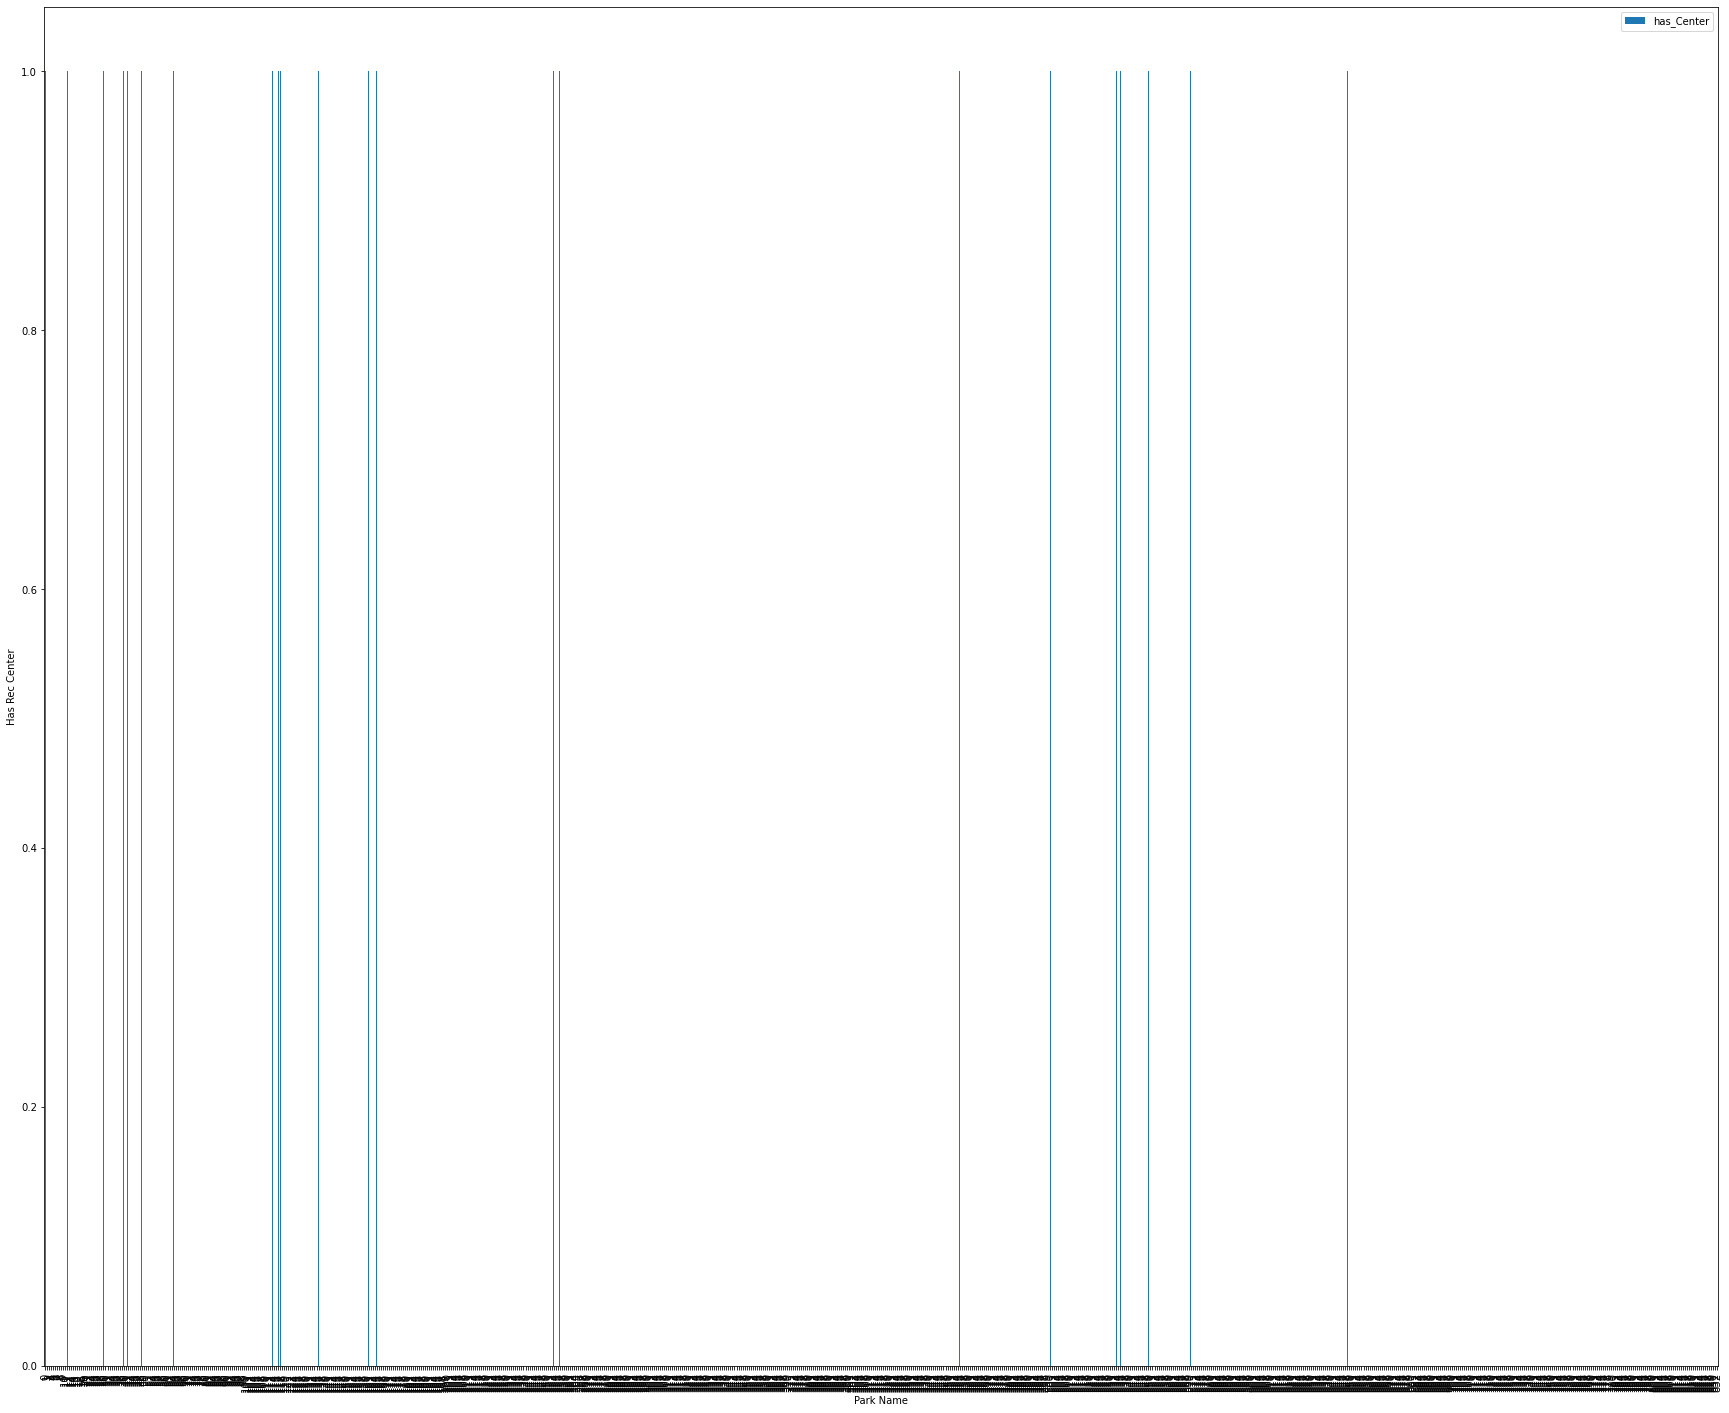

In [5]:
park_hasCenter = yelp_parks_df[['name','has_Center']]

plot1 = park_hasCenter.plot.bar(figsize=(30,25))
plot1 = plt.xlabel('Park Name')
plot1 = plt.ylabel('Has Rec Center')
plot1 = plt.rcParams.update({'font.size': 21})
plot1 = plt.gcf()


# Data Analysis & Results

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*